## Import libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

RANDOM_STATE = 404

C:\Users\pieni\AppData\Local\Temp\ipykernel_25672\3127632562.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load dataset:

In [3]:
df = pd.read_csv('HAD/HAD.csv')
df.dropna()
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


### Standardize the data

In [4]:
scaled_data = StandardScaler().fit_transform(df)
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


# Gaussian Mixture Model

### Determining the optimal number of clusters for a Gaussian Mixture Model using Bayesian Information Criterion 

In [5]:
bic_values = []
components_range = range(1, df.shape[1])

for n_components in components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
    gmm.fit(scaled_data)
    bic_values.append(gmm.bic(scaled_data))

# Find the number of components with the lowest BIC
best_n_components = np.argmin(bic_values) + 1

print("Optimal number of components:", best_n_components)

Optimal number of components: 7


### Fitting the GMM and getting the cluster labels

In [6]:
gmm = GaussianMixture(n_components=best_n_components, random_state=RANDOM_STATE)
gmm.fit(scaled_data)

labels = gmm.predict(scaled_data)

df['cluster_label'] = labels
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO,cluster_label
0,70,0,0,3,0,-1,1,0,0,0,...,0,96,0,180,0,-1,1,0,0,4
1,55,0,0,6,0,142,0,3,0,0,...,0,104,0,165,0,-1,1,4,1,2
2,73,0,0,3,0,170,0,0,0,1,...,1,-1,1,-1,1,-1,1,2,0,1
3,81,0,0,10,0,-1,1,0,0,0,...,0,90,0,115,0,-1,1,3,1,4
4,81,0,1,11,0,-1,1,0,0,0,...,0,110,0,120,0,-1,1,0,0,2


### Cluster mean values

In [7]:
cluster_means = df.groupby('cluster_label').mean()
print(cluster_means)

                     AGE  AGE_MISSING     SEX_F   NIHSS_BL  NIHSS_BL_MISSING  \
cluster_label                                                                  
0              69.474138     0.000000  0.474138  15.379310          0.000000   
1              74.804511     0.000000  0.451128   5.473684          0.142857   
2              65.918182     0.000000  0.318182   5.409091          0.009091   
3              70.213974     0.000000  0.502183  16.685590          0.000000   
4              73.447514     0.000000  0.436464   9.331492          0.000000   
5              61.485714     0.028571  0.457143   1.435714          0.071429   
6              72.657143     0.000000  0.542857  16.371429          0.028571   

               SYS_BLOOD_PRESSURE  SYS_BLOOD_PRESSURE_MISSING  PREV_MRS  \
cluster_label                                                             
0                       14.336207                    0.905172  0.577586   
1                      146.172932                    0

### Clusters visualization

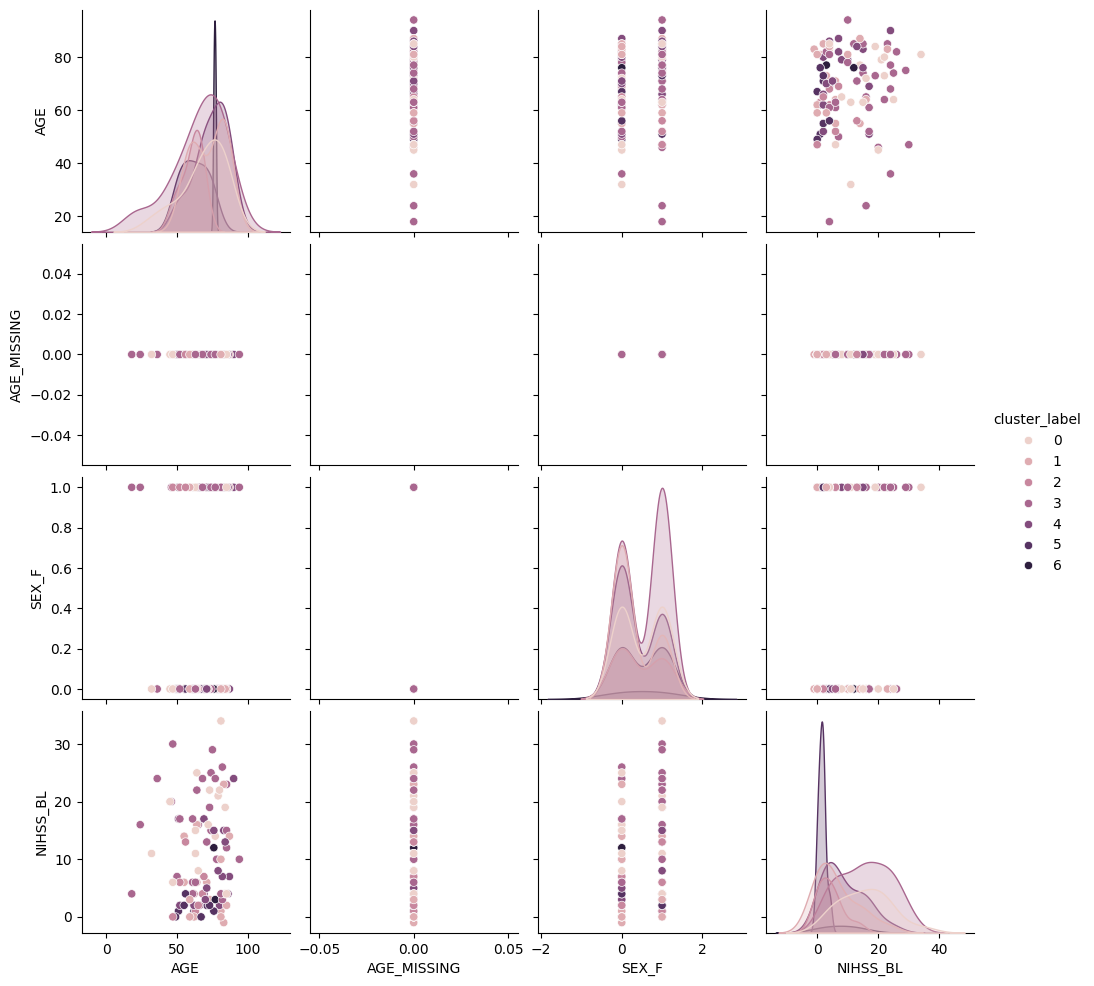

In [8]:
sns.pairplot(df.sample(100), hue='cluster_label', vars=df.columns[:4])
plt.show()

### Cluster sizes

In [9]:
cluster_sizes = df['cluster_label'].value_counts()
print(cluster_sizes)

cluster_label
3    229
4    181
5    140
1    133
0    116
2    110
6     35
Name: count, dtype: int64


### Feature importance

In [10]:
feature_importance = gmm.weights_
print("Feature Importance:", feature_importance)

Feature Importance: [0.12288136 0.14088987 0.11652542 0.24258475 0.19173729 0.14830505
 0.03707627]


# Kernel Density Estimation

In [18]:
bandwidth = 0.5

kde = KernelDensity(bandwidth=bandwidth)
kde.fit(scaled_data)

KernelDensity(bandwidth=0.5)

### Generate samples from the KDE model

In [19]:
samples = kde.sample(len(scaled_data), random_state=RANDOM_STATE)
samples

array([[ 0.77034113, -0.13939158,  1.06917286, ..., -1.29781054,
        -1.80016   , -0.72778606],
       [ 1.53993499,  0.20409402,  0.45085018, ...,  0.80334273,
         1.11499299,  1.06441199],
       [ 1.50374378, -0.10166469, -1.04315008, ...,  0.68299244,
         1.49293724,  2.03860704],
       ...,
       [ 1.02103287,  0.38929302,  0.62399553, ...,  0.09275562,
         0.45582663,  1.01972643],
       [ 0.55076423,  0.53064802, -1.07404532, ...,  1.36388859,
         0.74469036,  1.59665832],
       [ 1.60580069,  0.29464032,  1.21751856, ..., -0.45901319,
         1.44664834,  1.00579672]])

### Get the log likelihood of the samples

In [20]:
log_likelihood = kde.score_samples(scaled_data)
log_likelihood

array([-16.33335171, -16.3333362 , -16.33336297, -16.33336298,
       -16.33335507, -16.33336133, -16.33336298, -16.33336298,
       -16.3284322 , -16.33336298, -16.33336298, -16.33336296,
       -16.33336273, -16.33336298, -16.33336298, -16.33336298,
       -16.33336297, -16.33336298, -16.33336298, -16.33333025,
       -16.33336277, -16.33335413, -16.33336292, -16.33336297,
       -16.28938928, -16.33336296, -16.33336298, -16.33336298,
       -16.27373087, -16.33336298, -16.33328836, -16.33336264,
       -16.33336298, -16.33336298, -16.33336066, -16.33336298,
       -16.33336013, -16.2736358 , -16.33336298, -16.30502437,
       -16.33336298, -16.33336298, -16.33336297, -16.33336298,
       -16.3333596 , -16.33313493, -16.33336237, -16.33336289,
       -16.33336236, -16.33336298, -16.33334954, -16.33336298,
       -16.33336298, -16.33336298, -16.28777142, -16.3333175 ,
       -15.9654925 , -16.33333947, -16.3333458 , -16.33336298,
       -16.33333853, -16.33336298, -16.33336298, -16.33

### Visualize

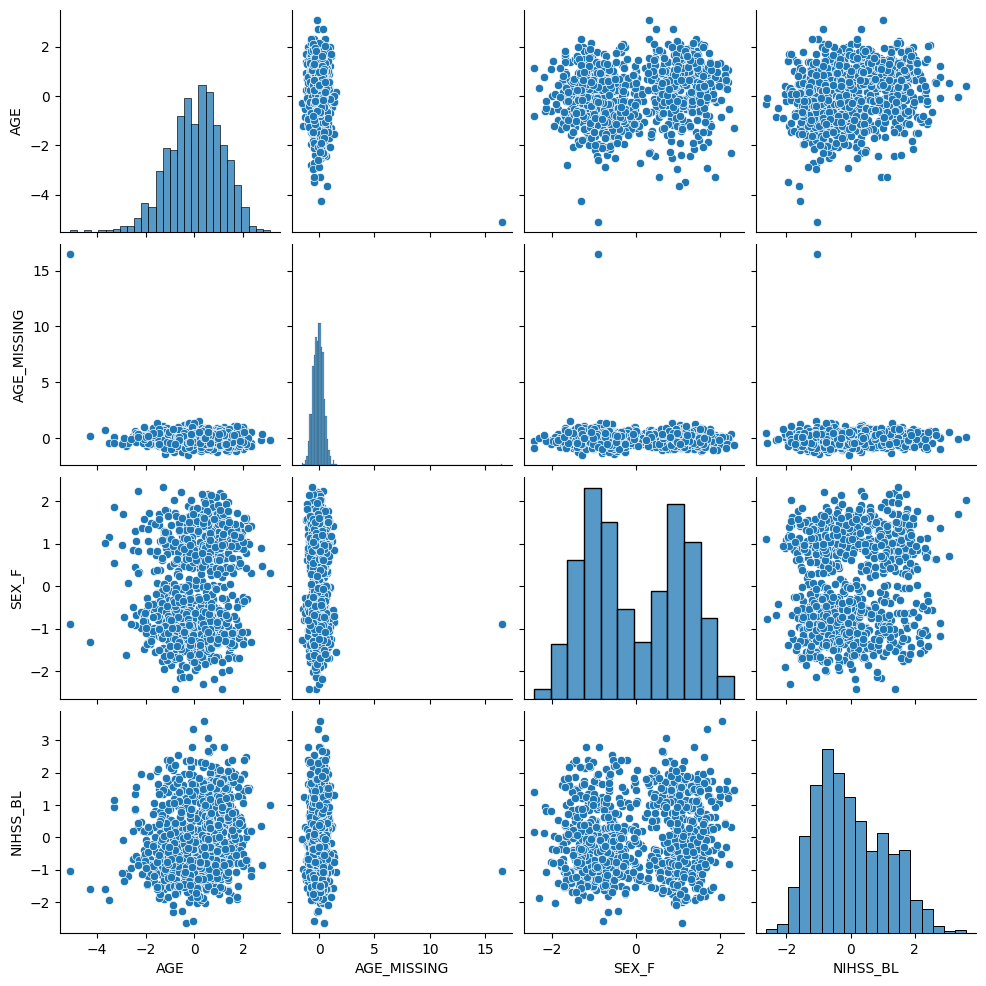

In [21]:
sns.pairplot(pd.DataFrame(samples[:, :4], columns=df.columns[:4]))
plt.show()